In [1]:
%config InlineBackend.figure_format = 'retina'
%matplotlib inline
import os
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from tqdm import tqdm
sns.set_palette('Dark2')
sns.set_style({'axes.axisbelow': True, 'axes.edgecolor': '.15', 'axes.facecolor': 'white',
               'axes.grid': True, 'axes.labelcolor': '.15', 'axes.linewidth': 1.25, 
               'figure.facecolor': 'white', 'font.family': ['sans-serif'], 'grid.color': '.15',
               'grid.linestyle': ':', 'grid.alpha': .5, 'image.cmap': 'Greys', 
               'legend.frameon': False, 'legend.numpoints': 1, 'legend.scatterpoints': 1,
               'lines.solid_capstyle': 'round', 'axes.spines.right': False, 'axes.spines.top': False,  
               'text.color': '.15',  'xtick.top': False, 'ytick.right': False, 'xtick.color': '.15',
               'xtick.direction': 'out', 'xtick.major.size': 6, 'xtick.minor.size': 3,
               'ytick.color': '.15', 'ytick.direction': 'out', 'ytick.major.size': 6,'ytick.minor.size': 3})
sns.set_context('paper')

#http://phyletica.org/matplotlib-fonts/
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

Set up

In [2]:
from snapanalysis.config import OUTPUT_DIRECTORY as MAIN_OUTPUT_DIRECTORY
OUTPUT_DIRECTORY = os.path.join(MAIN_OUTPUT_DIRECTORY, 'ptm-response')

if not os.path.isdir(OUTPUT_DIRECTORY):
    os.makedirs(OUTPUT_DIRECTORY)
    
def output_path(basename):
    return os.path.join(OUTPUT_DIRECTORY, basename)

Metadata for Pull-downs

In [3]:
from snapanalysis.preprocessing.pulldown_metadata import OUTPUT_FILE as META_FILE
with pd.HDFStore(META_FILE, 'r') as store:
    for key in store.keys():
        print(key)
    pd_predictor_matrix = store['/meta/predictors']
    n_predictors = pd_predictor_matrix.sum(axis=1)
    
    pd_names = store['/meta/names_and_types']

from snapanalysis.models.ptm_response.predictor_graph import EDGE_SEPARATOR, SPECIAL_PULLDOWN
def parse_edge(edge):
    left, __, right = edge.partition(EDGE_SEPARATOR)
    
    
    if right == SPECIAL_PULLDOWN:
        return [left]
    else:
        return [left, right]
    
def edge_sortkey(edge):
    edge = parse_edge(edge)
    return (len(edge), min([n_predictors.loc[x] for x in edge]))

def edge_name(edge):
    edge = parse_edge(edge)
    
    max_pd = max(edge, key=lambda x: n_predictors.loc[x])
    
    return pd_names.loc[max_pd, 'Pull-Down name'].strip()



/meta/color_palette
/meta/coloured_predictors
/meta/coloured_predictors_directionalised
/meta/coloured_predictors_directionalised_with_nulls
/meta/coloured_predictors_with_nulls
/meta/dates
/meta/dna
/meta/names_and_types
/meta/octamers
/meta/octamers_categorical
/meta/predictors
/meta/predictors_categorical
/meta/predictors_categorical_directionalised
/meta/predictors_categorical_directionalised_long
/meta/predictors_web
/meta/predictors_with_redundancy


Main data from limma

In [4]:
from snapanalysis.models.ptm_response.main import OUTPUT_FILE as PTM_RESPONSE_FILE

limma_results = pd.read_hdf(PTM_RESPONSE_FILE, '/ptm_stats/joint_limma_stats')

long_matrices = {}

for predictor in limma_results.reset_index()['predictor'].unique():
    long_matrices[predictor] = pd.read_hdf(PTM_RESPONSE_FILE, f'/ptm_stats/{predictor}/long_matrix')

Matrix for mean normed ratios (i.e. effects)

In [5]:
mean_effect_matrices = {}

for predictor, lm in long_matrices.items():
    lm = lm.reset_index()
    mnrm = lm.query('ptm == True')
    mnrm = mnrm.groupby(['Gene label', 'edge'])['normed_ratio'].mean()
    mnrm = mnrm.unstack('edge')
    
    edge_order = sorted(mnrm.columns, key=edge_sortkey)
    
    mnrm = mnrm.reindex(edge_order, axis=1)
    
    mean_effect_matrices[predictor] = mnrm

Protein metadata (and it's formatting)

In [6]:
from snapanalysis.preprocessing.protein_metadata import get_generic_metadata, get_complex_memberships

complex_memberships = get_complex_memberships()
complex_memberships = complex_memberships.groupby(level='Gene label').apply(lambda x: ';'.join(sorted(set(x))))
complex_memberships.name = 'Complex'

In [7]:
protein_metadata = get_generic_metadata().join(complex_memberships)
# Cheat a bit and have gene label twice. will make it easier
protein_metadata['Gene label'] = protein_metadata.index

protein_metadata = protein_metadata[['Gene label', 'symbol', 'alias', 'name', 'Complex']].rename(columns={'symbol': 'Symbol',
                                                                                            'alias': 'Other Names', 
                                                                                            'name': 'Name'})

protein_metadata = protein_metadata.fillna('').astype(str)



In [8]:
from snapanalysis.models.ptm_response.main import PREDICTOR_ORDER
predictors = PREDICTOR_ORDER

predictors_from_limma = limma_results.reset_index()['predictor'].unique()
assert all(p in predictors_from_limma for p in predictors)
assert all(p in predictors for p in predictors_from_limma)

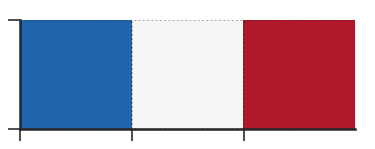

In [9]:
palette = sns.color_palette('RdBu_r', 9).as_hex()
blue = palette[0]
red = palette[-1]
white = palette[4]

sns.palplot([blue, white, red])

In [10]:
vmin = -1.5
vmax = 1.5

In [11]:
from snapanalysis.models.ptm_response.main import FDR_THRESHOLD_RESPONSE
FDR_THRESHOLD_RESPONSE

0.01

In [12]:
 lr = limma_results.loc[predictor].copy()
lr

,logFC,CI.L,CI.R,AveExpr,t,P.Value,adj.P.Val,B,shrunkFC,df_total,moderated_t_stdev,logFC_variance,confint_half_width,neg_log10_p,neg_log10_p_adjust,significant,significant_and_large_fc
Gene label,,,,,,,,,,,,,,,,,
CBX8,1.545431,1.450417,1.640444,0.939469,34.037253,1.572079e-18,2.490173e-15,32.373565,1.329322,19.054076,0.045404,0.002303,0.095014,17.803526,14.603770,True,True
CHD4,1.458938,1.321718,1.596159,0.174264,22.248957,4.267180e-15,2.024933e-12,24.825482,0.998598,19.054076,0.065573,0.004804,0.137220,14.369859,11.693589,True,True
KPNA2,2.063092,1.867128,2.259056,1.144509,22.030962,5.113468e-15,2.024933e-12,24.467311,1.505890,19.054076,0.093645,0.009798,0.195964,14.291284,11.693589,True,True
"ACT[A1,A2,C1,G2]",1.551816,1.406895,1.696737,1.368191,22.407837,3.743894e-15,2.024933e-12,24.442270,1.368402,19.054076,0.069253,0.005358,0.144921,14.426676,11.693589,True,True
SMARCE1,5.732503,5.174753,6.290253,3.126400,21.507777,7.948327e-15,2.518030e-12,24.085810,1.355189,19.054076,0.266532,0.079370,0.557750,14.099724,11.598939,True,True
REST,1.331614,1.197117,1.466111,0.634765,20.718378,1.576228e-14,4.161241e-12,23.523754,0.960249,19.054076,0.064272,0.004615,0.134497,13.802381,11.380777,True,True
MTA2,1.381114,1.238781,1.523446,-0.178251,20.305602,2.276537e-14,4.161967e-12,23.137482,0.916009,19.054076,0.068016,0.005169,0.142333,13.642725,11.380701,True,True
DNMT1 (1),1.228020,1.101430,1.354611,-0.101943,20.299949,2.288136e-14,4.161967e-12,23.105013,0.833395,19.054076,0.060494,0.004089,0.126591,13.640518,11.380701,True,True
UHRF1,1.527296,1.365996,1.688596,-0.259019,19.814327,3.558059e-14,4.734389e-12,22.672145,0.894619,19.054076,0.077080,0.006638,0.161300,13.448787,11.324736,True,True


In [13]:
import xlsxwriter

output_excel_filename = os.path.join(OUTPUT_DIRECTORY, 'ptm-response.xlsx')

writer = pd.ExcelWriter(output_excel_filename, engine='xlsxwriter')
workbook  = writer.book

format_header_level_two = workbook.add_format({'bold': True})
format_header_level_two.set_bottom(1) # add border
# format_header_level_two.set_shrink()

format_header_level_one = workbook.add_format({'bold': True})
format_header_level_one.set_right(1) # add border

format_header_level_two_corner = workbook.add_format({'bold': True})
# format_header_level_two_corner.set_shrink()
format_header_level_two_corner.set_right(1) # add border
format_header_level_two_corner.set_bottom(1) # add border

format_bold = workbook.add_format({'bold': True})

# Format for groups - border
format_group_right_edge = workbook.add_format()
format_group_right_edge.set_right(1)


conditional_format_options = {
  'type': '3_color_scale',
  'min_value': vmin,
  'max_value': vmax,
  'mid_value': 0,
  'min_type': 'num',
  'max_type': 'num',
  'mid_type': 'num',
  'min_color': blue,
  'mid_color': white,
  'max_color': red
}

for predictor in tqdm(predictors):
    
    lr = limma_results.loc[predictor].copy()
    
    abs_fc = lr['logFC'].abs()
    order = lr.sort_values(by='adj.P.Val').index
    
    lr = lr[['logFC', 'confint_half_width', 'logFC_variance', 't', 'P.Value', 'adj.P.Val', 
             'df_total', 'moderated_t_stdev']]
    lr = lr.reindex(order)
    
    lr = lr.rename(columns={'logFC': 'Effect', 
                            'confint_half_width': '95% CI (+/-)',
                            't': 't statistic (moderated)',
                            'P.Value': 'P value',
                            'adj.P.Val': 'P value (adjusted)',
                            'df_total': 'Moderated t distribution dof',
                            'moderated_t_stdev': 'Moderated t distribution stdev',
                            'logFC_variance': 'logFC variance'})
    
    
    
    meta = protein_metadata.loc[lr.index].copy()
    
    effects = mean_effect_matrices[predictor].loc[lr.index].copy()
    effects.columns = ['{} ({})'.format(edge, edge_name(edge)) for edge in effects.columns]
#     effects.columns = pd.
    
    
    output_df = meta.join(lr).join(effects)
    
    
    first_row_data = 2
    last_row_data = first_row_data + len(output_df)  - 1
    # Write main data
    output_df.to_excel(writer, 
                       sheet_name=predictor, 
                       startrow=first_row_data,
                       index=False, header=False)
    
    worksheet = writer.sheets[predictor]
    
 
    
    # Write column groups (first level headers)
    first_col_meta = 0
    last_col_meta = len(meta.columns)-1
    first_col_stats = last_col_meta + 1
    last_col_stats = first_col_stats + len(lr.columns) - 1
    first_col_effect = last_col_stats + 1
    last_col_effect = first_col_effect + len(effects.columns) - 1
    
    # Write columns (second level headers)
    for i, col in enumerate(output_df.columns):
        if i == last_col_meta:
            format_ = format_header_level_two_corner
        else:
            format_ = format_header_level_two
            
        worksheet.write_string(1, i, col, format_)

    worksheet.merge_range(0, first_col_meta, 0, last_col_meta, 'Metadata', format_header_level_one)
    worksheet.set_column(first_col_meta, last_col_meta, 20)
    worksheet.set_column(last_col_meta, last_col_meta, cell_format=format_group_right_edge)
    worksheet.merge_range(0, first_col_stats, 0, last_col_stats, 'Statistics', format_header_level_one)
    worksheet.set_column(first_col_stats, last_col_stats, 10)
    worksheet.set_column(last_col_stats, last_col_stats, cell_format=format_group_right_edge)
    worksheet.merge_range(0, first_col_effect, 0, last_col_effect, 'Average effect per pull-down pair', format_header_level_one)
    worksheet.set_column(first_col_effect, last_col_effect, 10)
    worksheet.set_column(last_col_effect, last_col_effect, cell_format=format_group_right_edge)
       
    col_effect = first_col_stats + list(lr.columns).index('Effect')
    col_p_value = first_col_stats + list(lr.columns).index('P value (adjusted)')
    
#     col_shrunk_effect = first_col_stats + list(lr.columns).index('Effect (moderated)')

    worksheet.conditional_format(first_row_data, col_effect,
                                 last_row_data, col_effect, 
                                 conditional_format_options)
    
    worksheet.conditional_format(first_row_data, first_col_effect,
                                 last_row_data, last_col_effect, 
                                 conditional_format_options)
    
    worksheet.conditional_format(first_row_data, col_p_value, last_row_data, col_p_value, 
                                 {'type':     'cell',
                                 'criteria': 'less than or equal to',
                                 'value':    FDR_THRESHOLD_RESPONSE,
                                 'format':   format_bold})

    
    worksheet.freeze_panes(first_row_data, first_col_stats)
    worksheet.autofilter(first_row_data-1, 0, last_row_data, last_col_effect)
    


writer.save()


100%|██████████| 15/15 [00:04<00:00,  3.12it/s]


In [14]:
from helpers import *

In [15]:
predictor_sorted_uri('H3ac', members_of('INO80'))

'http://ife-snap-data/proteins?pdorder=H05,H10,H02,H12,H16,H20,H21,H25,H22,H26,H41,H43&k=p:ACTL6A&k=p:ACTR5&k=p:ACTR8&k=p:INO80&k=p:INO80B&k=p:INO80C&k=p:INO80D&k=p:INO80E&k=p:MCRS1&k=p:NFRKB&k=p:RUVBL1&k=p:RUVBL2&k=p:TFPT&k=p:UCHL5&k=p:YY1&showsimilar=false&noclusterproteins=true'